<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1. Solution
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competiton](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [15]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

Reading original data

In [2]:
PATH_TO_DATA = ('/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/competitions/kaggle_alice/')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

Separate target feature 

In [3]:
y = train_df['target']

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [4]:
train = train_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
test = test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

train_text = [' '.join([str(i) for i in j]) for j in train.values]
text_text = [' '.join([str(i) for i in j]) for j in test.values]


In [5]:
%%time
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)
train_tfidf = tfidf_vectorizer.fit_transform(train_text)
test_tfidf = tfidf_vectorizer.transform(text_text)

CPU times: user 14.6 s, sys: 431 ms, total: 15 s
Wall time: 15.1 s


In [6]:
train_tfidf.shape, test_tfidf.shape

((253561, 100000), (82797, 100000))

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [7]:
train_df['time1'] = train_df['time1'].apply(lambda t: pd.to_datetime(t))
test_df['time1'] = test_df['time1'].apply(lambda t: pd.to_datetime(t))

train_df['start_hour'] = train_df['time1'].apply(lambda x: x.hour).fillna(-1)
train_df['year_month'] = train_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).fillna(-1)
train_df['morning'] = (train_df.start_hour <= 11).astype('int')
train_df['day'] = ((train_df.start_hour > 11) & (train_df.start_hour <=18)).astype('int')
train_df['week_hour'] = train_df['time1'].apply(lambda x: x.dayofweek * 24 + x.hour).fillna(-1)

test_df['start_hour'] = test_df['time1'].apply(lambda x: x.hour).fillna(-1)
test_df['year_month'] = test_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).fillna(-1)
test_df['morning'] = (test_df.start_hour <= 11).astype('int')
test_df['day'] = ((test_df.start_hour > 11) & (test_df.start_hour <=18)).astype('int')
test_df['week_hour'] = test_df['time1'].apply(lambda x: x.dayofweek * 24 + x.hour).fillna(-1)

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [8]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_df[['year_month', 'morning', 'day', 'week_hour']])
test_features_scaled = scaler.transform(test_df[['year_month', 'morning', 'day', 'week_hour']])

In [9]:
X_train_sparse = csr_matrix(hstack([train_tfidf, train_features_scaled]))
X_test_sparse = csr_matrix(hstack([test_tfidf, test_features_scaled]))

Perform cross-validation with logistic regression.

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [16]:
%%time
lcv = LogisticRegressionCV(Cs=np.linspace(1e-1, 1e1, 10), 
                           scoring='roc_auc', n_jobs=-1, class_weight='balanced', cv=skf, verbose=1,
                           random_state=17)
lcv.fit(X=X_train_sparse, y=y)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


CPU times: user 5.43 s, sys: 304 ms, total: 5.74 s
Wall time: 1min 20s


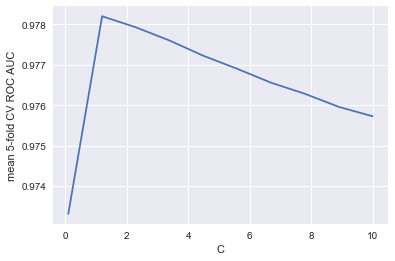

In [17]:
plt.plot(np.linspace(1e-1, 1e1, 10), lcv.scores_[1].mean(axis=0));
plt.xlabel('C')
plt.ylabel('mean 5-fold CV ROC AUC');

Make prediction for the test set and form a submission file.

In [18]:
test_pred = lcv.predict_proba(X_test_sparse)[:, 1]

In [19]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [20]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")